In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

# File to Load (Remember to Change These)
mouse_drug_data_to_load = "data/mouse_drug_data.csv"
clinical_trial_data_to_load = "data/clinicaltrial_data.csv"

# Read the Mouse and Drug Data and the Clinical Trial Data
mouseDF = pd.read_csv(mouse_drug_data_to_load)
clinicalDF = pd.read_csv(clinical_trial_data_to_load)

# Combine the data into a single dataset
outcomesDF = pd.merge(mouseDF, clinicalDF, how="left", on="Mouse ID")

# Display the data table for preview
outcomesDF.head()

,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites
0,f234,Stelasyn,0,45.000000,0
1,f234,Stelasyn,5,47.313491,0
2,f234,Stelasyn,10,47.904324,0
3,f234,Stelasyn,15,48.735197,1
4,f234,Stelasyn,20,51.112713,2


In [2]:
# Verifies unique mouse count is off (should be 25 for each trial)
mice = outcomesDF.loc[outcomesDF["Timepoint"]==0, "Mouse ID"].unique().size

# Isolating a single row using Timepoint column as identifier to check for duplicates
time0 = outcomesDF.loc[outcomesDF["Timepoint"]==0]
miceDups = time0.duplicated(keep=False)
# Identifies g989 as multi-trial, faulty data mouse
time0[miceDups]

# Dropped mouse g989 from analysis due to lack of verification which trial this mouse actually belongs to
outcomesDF.drop(outcomesDF[outcomesDF["Mouse ID"]=="g989"].index, inplace=True)

In [3]:
time0 = outcomesDF.loc[outcomesDF["Timepoint"]==0]
miceDups = time0.duplicated(keep=False)
# Rechecking for duplicate mice
time0[miceDups]

,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites


## Tumor Response to Treatment

In [4]:
# Store the Mean Tumor Volume Data Grouped by Drug and Timepoint 
meanTumorVolume = outcomesDF.groupby(["Drug", "Timepoint"])["Tumor Volume (mm3)"].mean()
drugs = outcomesDF["Drug"].unique()
drugs.sort()
# Convert to DataFrame
meanTVDF = pd.DataFrame(meanTumorVolume).rename(columns={"Tumor Volume (mm3)": "Tumor Volume (mm3) Mean"})

# Preview DataFrame
meanTVDF.head()

Tumor Volume (mm3) Mean
Drug      Timepoint                         
Capomulin 0                        45.000000
          5                        44.266086
          10                       43.084291
          15                       42.064317
          20                       40.716325

In [5]:
# Store the Standard Error of Tumor Volumes Grouped by Drug and Timepoint
stderrTumorVolume = outcomesDF.groupby(["Drug", "Timepoint"])["Tumor Volume (mm3)"].sem()

# Convert to DataFrame
stderrTVDF = pd.DataFrame(stderrTumorVolume).rename(columns={"Tumor Volume (mm3)": "Tumor Volume (mm3) Standard Error"})

# Preview DataFrame
stderrTVDF.head()

Tumor Volume (mm3) Standard Error
Drug      Timepoint                                   
Capomulin 0                                   0.000000
          5                                   0.448593
          10                                  0.702684
          15                                  0.838617
          20                                  0.909731

In [6]:
# Minor Data Munging to Re-Format the Data Frames
resetTVDF = meanTVDF.reset_index()
mungedDF = resetTVDF.pivot(index="Timepoint", columns="Drug", values="Tumor Volume (mm3) Mean")
# Preview that Reformatting worked
mungedDF.head()

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
5,44.266086,46.503051,47.062001,47.389175,46.796098,47.125589,47.168130,43.944859,47.470830,46.851818
10,43.084291,48.285125,49.403909,49.582269,48.694210,49.423329,48.938560,42.531957,49.335368,48.689881
15,42.064317,50.094055,51.296397,52.399974,50.933018,51.359742,50.891769,41.495061,51.448025,50.779059
20,40.716325,52.157049,53.197691,54.920935,53.644087,54.364417,53.127384,40.238325,53.970080,53.170334


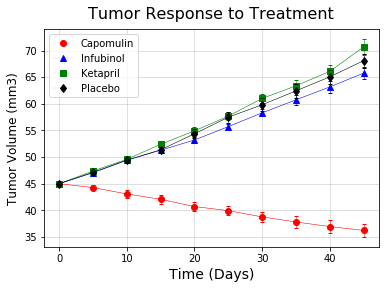

In [7]:
# Generate the Plot (with Error Bars)
x_axis = mungedDF.index.values

# Drug handles  
capomulin, = plt.plot(x_axis, mungedDF["Capomulin"].values, color="red", marker="o", ls="dashed", lw=0.1, label=drugs[0])
plt.errorbar(x_axis, mungedDF["Capomulin"].values, yerr = stderrTumorVolume["Capomulin"], color="red", capsize=2, lw=0.5)

infubinol, = plt.plot(x_axis, mungedDF["Infubinol"].values, color="blue", marker="^", ls="dashed", lw=0.1, label=drugs[2])
plt.errorbar(x_axis, mungedDF["Infubinol"].values, yerr = stderrTumorVolume["Infubinol"], color="blue", capsize=2, lw=0.5)

ketapril, = plt.plot(x_axis, mungedDF["Ketapril"].values, color="green", marker="s", ls="dashed", lw=0.1, label=drugs[3])
plt.errorbar(x_axis, mungedDF["Ketapril"].values, yerr = stderrTumorVolume["Ketapril"], color="green", capsize=2, lw=0.5)

placebo, = plt.plot(x_axis, mungedDF["Placebo"].values, color="black", marker="d", ls="-.", lw=0.1, label=drugs[5])
plt.errorbar(x_axis, mungedDF["Placebo"].values, yerr = stderrTumorVolume["Placebo"], color="black", capsize=2, lw=0.5)


# Labels/Formatting
plt.title("Tumor Response to Treatment", fontsize=16, fontname="Eras ITC").set_position([.5, 1.02])
plt.xlabel("Time (Days)", fontsize=14, fontname="Eras ITC")
plt.ylabel("Tumor Volume (mm3)", fontsize=12, fontname="Eras ITC")
plt.legend(loc="best", fontsize="medium", fancybox=True)
plt.grid(color='gray', linestyle='-', linewidth=.5, alpha=0.5)


# Save the Figure
plt.savefig("./Images/0TumorResponse.png")
plt.show()

## Metastatic Response to Treatment

In [9]:
# Store the Mean Met. Site Data Grouped by Drug and Timepoint 
meanMetaSites = outcomesDF.groupby(["Drug", "Timepoint"])["Metastatic Sites"].mean()

# Convert to DataFrame
meanMSDF = pd.DataFrame(meanMetaSites).rename(columns={"Metastatic Sites": "Metastatic Sites Mean"})

# Preview DataFrame
meanMSDF.head()

Metastatic Sites Mean
Drug      Timepoint                       
Capomulin 0                       0.000000
          5                       0.160000
          10                      0.320000
          15                      0.375000
          20                      0.652174

In [10]:
# Store the Standard Error associated with Met. Sites Grouped by Drug and Timepoint 
stderrMetaSites = outcomesDF.groupby(["Drug", "Timepoint"])["Metastatic Sites"].sem()

# Convert to DataFrame
stderrMSDF = pd.DataFrame(stderrMetaSites).rename(columns={"Metastatic Sites": "Metastatic Sites Standard Error"})

# Preview DataFrame
stderrMSDF.head()

Metastatic Sites Standard Error
Drug      Timepoint                                 
Capomulin 0                                 0.000000
          5                                 0.074833
          10                                0.125433
          15                                0.132048
          20                                0.161621

In [11]:
# Minor Data Munging to Re-Format the Data Frames
resetMSDF = meanMSDF.reset_index()
mungedMSDF = resetMSDF.pivot(index="Timepoint", columns="Drug", values="Metastatic Sites Mean")

# Preview that Reformatting worked
mungedMSDF.head()

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.160000,0.380952,0.280000,0.304348,0.260870,0.375000,0.347826,0.120000,0.260870,0.166667
10,0.320000,0.600000,0.666667,0.590909,0.523810,0.833333,0.619048,0.250000,0.523810,0.500000
15,0.375000,0.789474,0.904762,0.842105,0.857143,1.250000,0.800000,0.333333,0.809524,0.809524
20,0.652174,1.111111,1.050000,1.210526,1.150000,1.526316,1.000000,0.347826,0.947368,1.294118


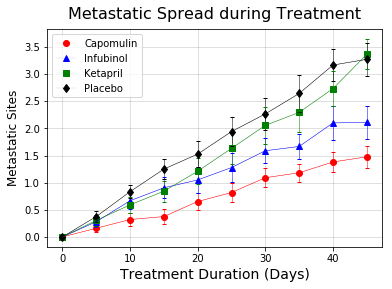

In [12]:
# Generate the Plot (with Error Bars)
x_axis = mungedMSDF.index.values


capomulinMS, = plt.plot(x_axis, mungedMSDF["Capomulin"].values, color="red", marker="o", ls="dashed", lw=0.1, label=drugs[0])
plt.errorbar(x_axis, mungedMSDF["Capomulin"].values, yerr = stderrMetaSites["Capomulin"], color="red", capsize=2, lw=0.5)

infubinolMS, = plt.plot(x_axis, mungedMSDF["Infubinol"].values, color="blue", marker="^", ls="dashed", lw=0.1, label=drugs[2])
plt.errorbar(x_axis, mungedMSDF["Infubinol"].values, yerr = stderrMetaSites["Infubinol"], color="blue", capsize=2, lw=0.5)

ketaprilMS, = plt.plot(x_axis, mungedMSDF["Ketapril"].values, color="green", marker="s", ls="dashed", lw=0.1, label=drugs[3])
plt.errorbar(x_axis, mungedMSDF["Ketapril"].values, yerr = stderrMetaSites["Ketapril"], color="green", capsize=2, lw=0.5)

placeboMS, = plt.plot(x_axis, mungedMSDF["Placebo"].values, color="black", marker="d", ls="dashed", lw=0.1, label=drugs[5])
plt.errorbar(x_axis, mungedMSDF["Placebo"].values, yerr = stderrMetaSites["Placebo"], color="black", capsize=2, lw=0.5)


plt.title("Metastatic Spread during Treatment", fontsize=16, fontname="Eras ITC").set_position([.5, 1.02])
plt.xlabel("Treatment Duration (Days)", fontsize=14, fontname="Eras ITC")
plt.ylabel("Metastatic Sites", fontsize=12, fontname="Eras ITC")
plt.legend(loc="best", fontsize="medium", fancybox=True)
plt.grid(color='gray', linestyle='-', linewidth=.5, alpha=0.5)


# Save the Figure
plt.savefig("./Images/1MetastaticSpread.png")

# Show the Figure
plt.show()

## Survival Rates

In [13]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)
mouseCount = outcomesDF.groupby(["Drug", "Timepoint"])["Mouse ID"].count()

# Convert to DataFrame
mouseDF = pd.DataFrame(mouseCount).rename(columns={"Mouse ID": "Mouse Count"})

# Preview DataFrame
mouseDF.head(5)

Mouse Count
Drug      Timepoint             
Capomulin 0                   25
          5                   25
          10                  25
          15                  24
          20                  23

In [14]:
# Minor Data Munging to Re-Format the Data Frames
resetMouseDF = mouseDF.reset_index()
mungedMouseDF = resetMouseDF.pivot(index="Timepoint", columns="Drug", values="Mouse Count")

# Preview that Reformatting worked
mungedMouseDF.head(20)

Drug,Capomulin,Ceftamin,Infubinol,Ketapril,Naftisol,Placebo,Propriva,Ramicane,Stelasyn,Zoniferol
Timepoint,,,,,,,,,,
0,25,25,25,25,25,25,24,25,24,25
5,25,21,25,23,23,24,23,25,23,24
10,25,20,21,22,21,24,21,24,21,22
15,24,19,21,19,21,20,15,24,21,21
20,23,18,20,19,20,19,15,23,19,17
25,22,18,18,19,18,17,13,23,18,16
30,22,16,17,18,15,15,12,23,17,15
35,22,14,12,17,15,14,9,21,15,14
40,21,14,10,15,15,12,9,20,12,14


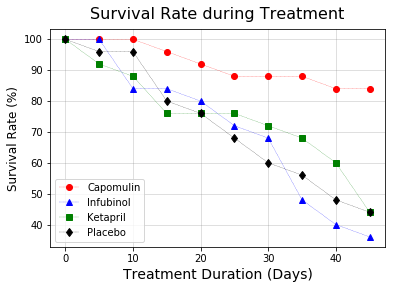

In [15]:
# Generate the Plot (Accounting for percentages)
x_axis = mungedMouseDF.index.values

capomulinMice, = plt.plot(x_axis, mungedMouseDF["Capomulin"].values/mungedMouseDF["Capomulin"].values[0]*100, color="red", marker="o", ls="dashed", lw=0.25, label=drugs[0])

infubinolMice, = plt.plot(x_axis, mungedMouseDF["Infubinol"].values/mungedMouseDF["Infubinol"].values[0]*100, color="blue", marker="^", ls="dashed", lw=0.25, label=drugs[2])

ketaprilMice, = plt.plot(x_axis, mungedMouseDF["Ketapril"].values/mungedMouseDF["Ketapril"].values[0]*100, color="green", marker="s", ls="dashed", lw=0.25, label=drugs[3])

placeboMice, = plt.plot(x_axis, mungedMouseDF["Placebo"].values/mungedMouseDF["Placebo"].values[0]*100, color="black", marker="d", ls="dashed", lw=0.25, label=drugs[5])


plt.title("Survival Rate during Treatment", fontsize=16, fontname="Eras ITC").set_position([.5, 1.02])
plt.xlabel("Treatment Duration (Days)", fontsize=14, fontname="Eras ITC")
plt.ylabel("Survival Rate (%)", fontsize=12, fontname="Eras ITC")
plt.legend(loc="best", fontsize="medium", fancybox=True)
plt.grid(color='gray', linestyle='-', linewidth=.5, alpha=0.5)


# Save the Figure
plt.savefig("./Images/2SurvivalRate.png")

# Show the Figure
plt.show()

## Summary Bar Graph

In [16]:
# Calculate the percent changes for each drug
def percentChange(drug, dataframe, column):
    values = dataframe[column][drug]
    start = values[0]
    end = values[45]
    return (end-start)/start*100

percents = []
for drug in drugs:
    pc = round(percentChange(drug, meanTVDF, "Tumor Volume (mm3) Mean"), 6)
    percents.append(pc)
    
# Display the data to confirm   
drugPercentChange = pd.Series(percents, drugs)
drugPercentChange.axes[0][0]
drugPercentChange

Capomulin   -19.475303
Ceftamin     42.516492
Infubinol    46.123472
Ketapril     57.028795
Naftisol     53.923347
Placebo      51.297960
Propriva     47.241175
Ramicane    -22.320900
Stelasyn     52.085134
Zoniferol    46.579751
dtype: float64

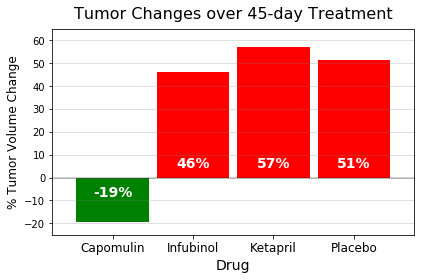

In [17]:
# Store all Relevant Percent Changes into a Tuple
relevDrugPct = ([drugPercentChange.axes[0][0], drugPercentChange[0]],
                [drugPercentChange.axes[0][2], drugPercentChange[2]],
                [drugPercentChange.axes[0][3], drugPercentChange[3]],
                [drugPercentChange.axes[0][5], drugPercentChange[5]])


relevDrugPctSeries = drugPercentChange.drop(labels=["Ceftamin", "Naftisol", "Propriva", "Ramicane", "Stelasyn", "Zoniferol"])
drugLabels = np.asarray(["Capomulin", "Infubinol", "Ketapril", "Placebo"])

# Splice the data between passing and failing drugs
passing = []
failing = []
count = 0 
for drug in relevDrugPct:
    drugIndex = relevDrugPct[count][1]
    if drugIndex>=0:
        failing.append(count)
    else:
        passing.append(count)
    count += 1

# Plot passing and failing values on bar graph
green = plt.bar(drugLabels[passing], relevDrugPctSeries[passing], width=.9, color='g', align="center")
red = plt.bar(drugLabels[failing], relevDrugPctSeries[failing], width=.9, color='r', align="center")



# Orient widths. Add labels, tick marks, etc. 
plt.title("Tumor Changes over 45-day Treatment", fontsize=16, fontname="Eras ITC").set_position([.5, 1.02])
plt.xticks(drugLabels, fontsize=12, fontname="Eras ITC")
plt.xlabel("Drug", fontsize=14, fontname="Eras ITC")
plt.ylabel("% Tumor Volume Change", fontsize=12, fontname="Eras ITC")
plt.ylim(-25, 65, 10)
x_lim = len(drugLabels)-.25
plt.xlim(-.75, x_lim)
plt.grid(color='gray', axis="y", linestyle='-', linewidth=.5, alpha=0.5)
plt.hlines(0, -.75, x_lim, alpha=.25)

# Use functions to label the percentages of changes
# Call functions to implement the function calls
space = 7.5
for rect in red.patches:
    x,y= rect.xy
    labelx = x + rect.get_width()/2
    labely = y
    labelval = rect.get_height()
    label = "{:.0f}%".format(labelval)

    plt.annotate(label,
                 (labelx, labely),
                 xytext=(0, space),
                 textcoords="offset points",
                 fontsize=14,
                 fontname="Eras ITC",
                 color="white",
                 weight="bold",
                 va='bottom',
                 ha="center") 

for rect in green.patches:
    x,y= rect.xy
    labelx = x + rect.get_width()/2
    labely = y
    labelval = rect.get_height()
    label = "{:.0f}%".format(labelval)    

    plt.annotate(label,
                 (labelx, labely),
                 xytext=(0, -space),
                 textcoords="offset points",
                 fontsize=14,
                 fontname="Eras ITC",
                 color="white",
                 weight="bold",
                 va='top',ha="center")     

plt.tight_layout()

# Save the Figure
plt.savefig("./Images/3PercentTumorChange.png")

# Show the Figure
plt.show()